# Question 1

In [46]:
from glob import glob
import numpy as np
import pandas as pd
root = "/Users/nhatpham/Downloads/Symbol/"


In [47]:
def markov(lang):
    " Language parameter can be A, B or C"
    matrix = pd.DataFrame(np.zeros((7,7)), index = ["A", "o", "e", "t", "p", "g", "k"], 
                                  columns = ["A", "o", "e", "t", "p", "g", "k"] )
    for j in range(0,30):
        file = "language-training-lang" + str(lang) +"-" + str(j)
        path = root + file
        text = open(path, "r").read()
        
        #next state is column, current state is row

        length = len(text)
        for i in range(length-1):
            cur = text[i]
            nex = text[i+1]
            matrix.loc[cur, nex] += 1
            
    for row_name, value in matrix.iterrows():
        matrix.loc[row_name,:] = value/value.sum()
        
    return(matrix)
    

In [48]:
markov("A")

,A,o,e,t,p,g,k
A,0.017677,0.020202,0.030303,0.265152,0.222222,0.232323,0.212121
o,0.016827,0.016827,0.026442,0.247596,0.233173,0.242788,0.216346
e,0.026570,0.028986,0.016908,0.219807,0.258454,0.241546,0.207729
t,0.019868,0.024283,0.028698,0.233996,0.229581,0.227373,0.236203
p,0.272109,0.294785,0.306122,0.045351,0.027211,0.036281,0.018141
g,0.264108,0.329571,0.277652,0.024831,0.049661,0.029345,0.024831
k,0.319410,0.245700,0.285012,0.041769,0.029484,0.036855,0.041769


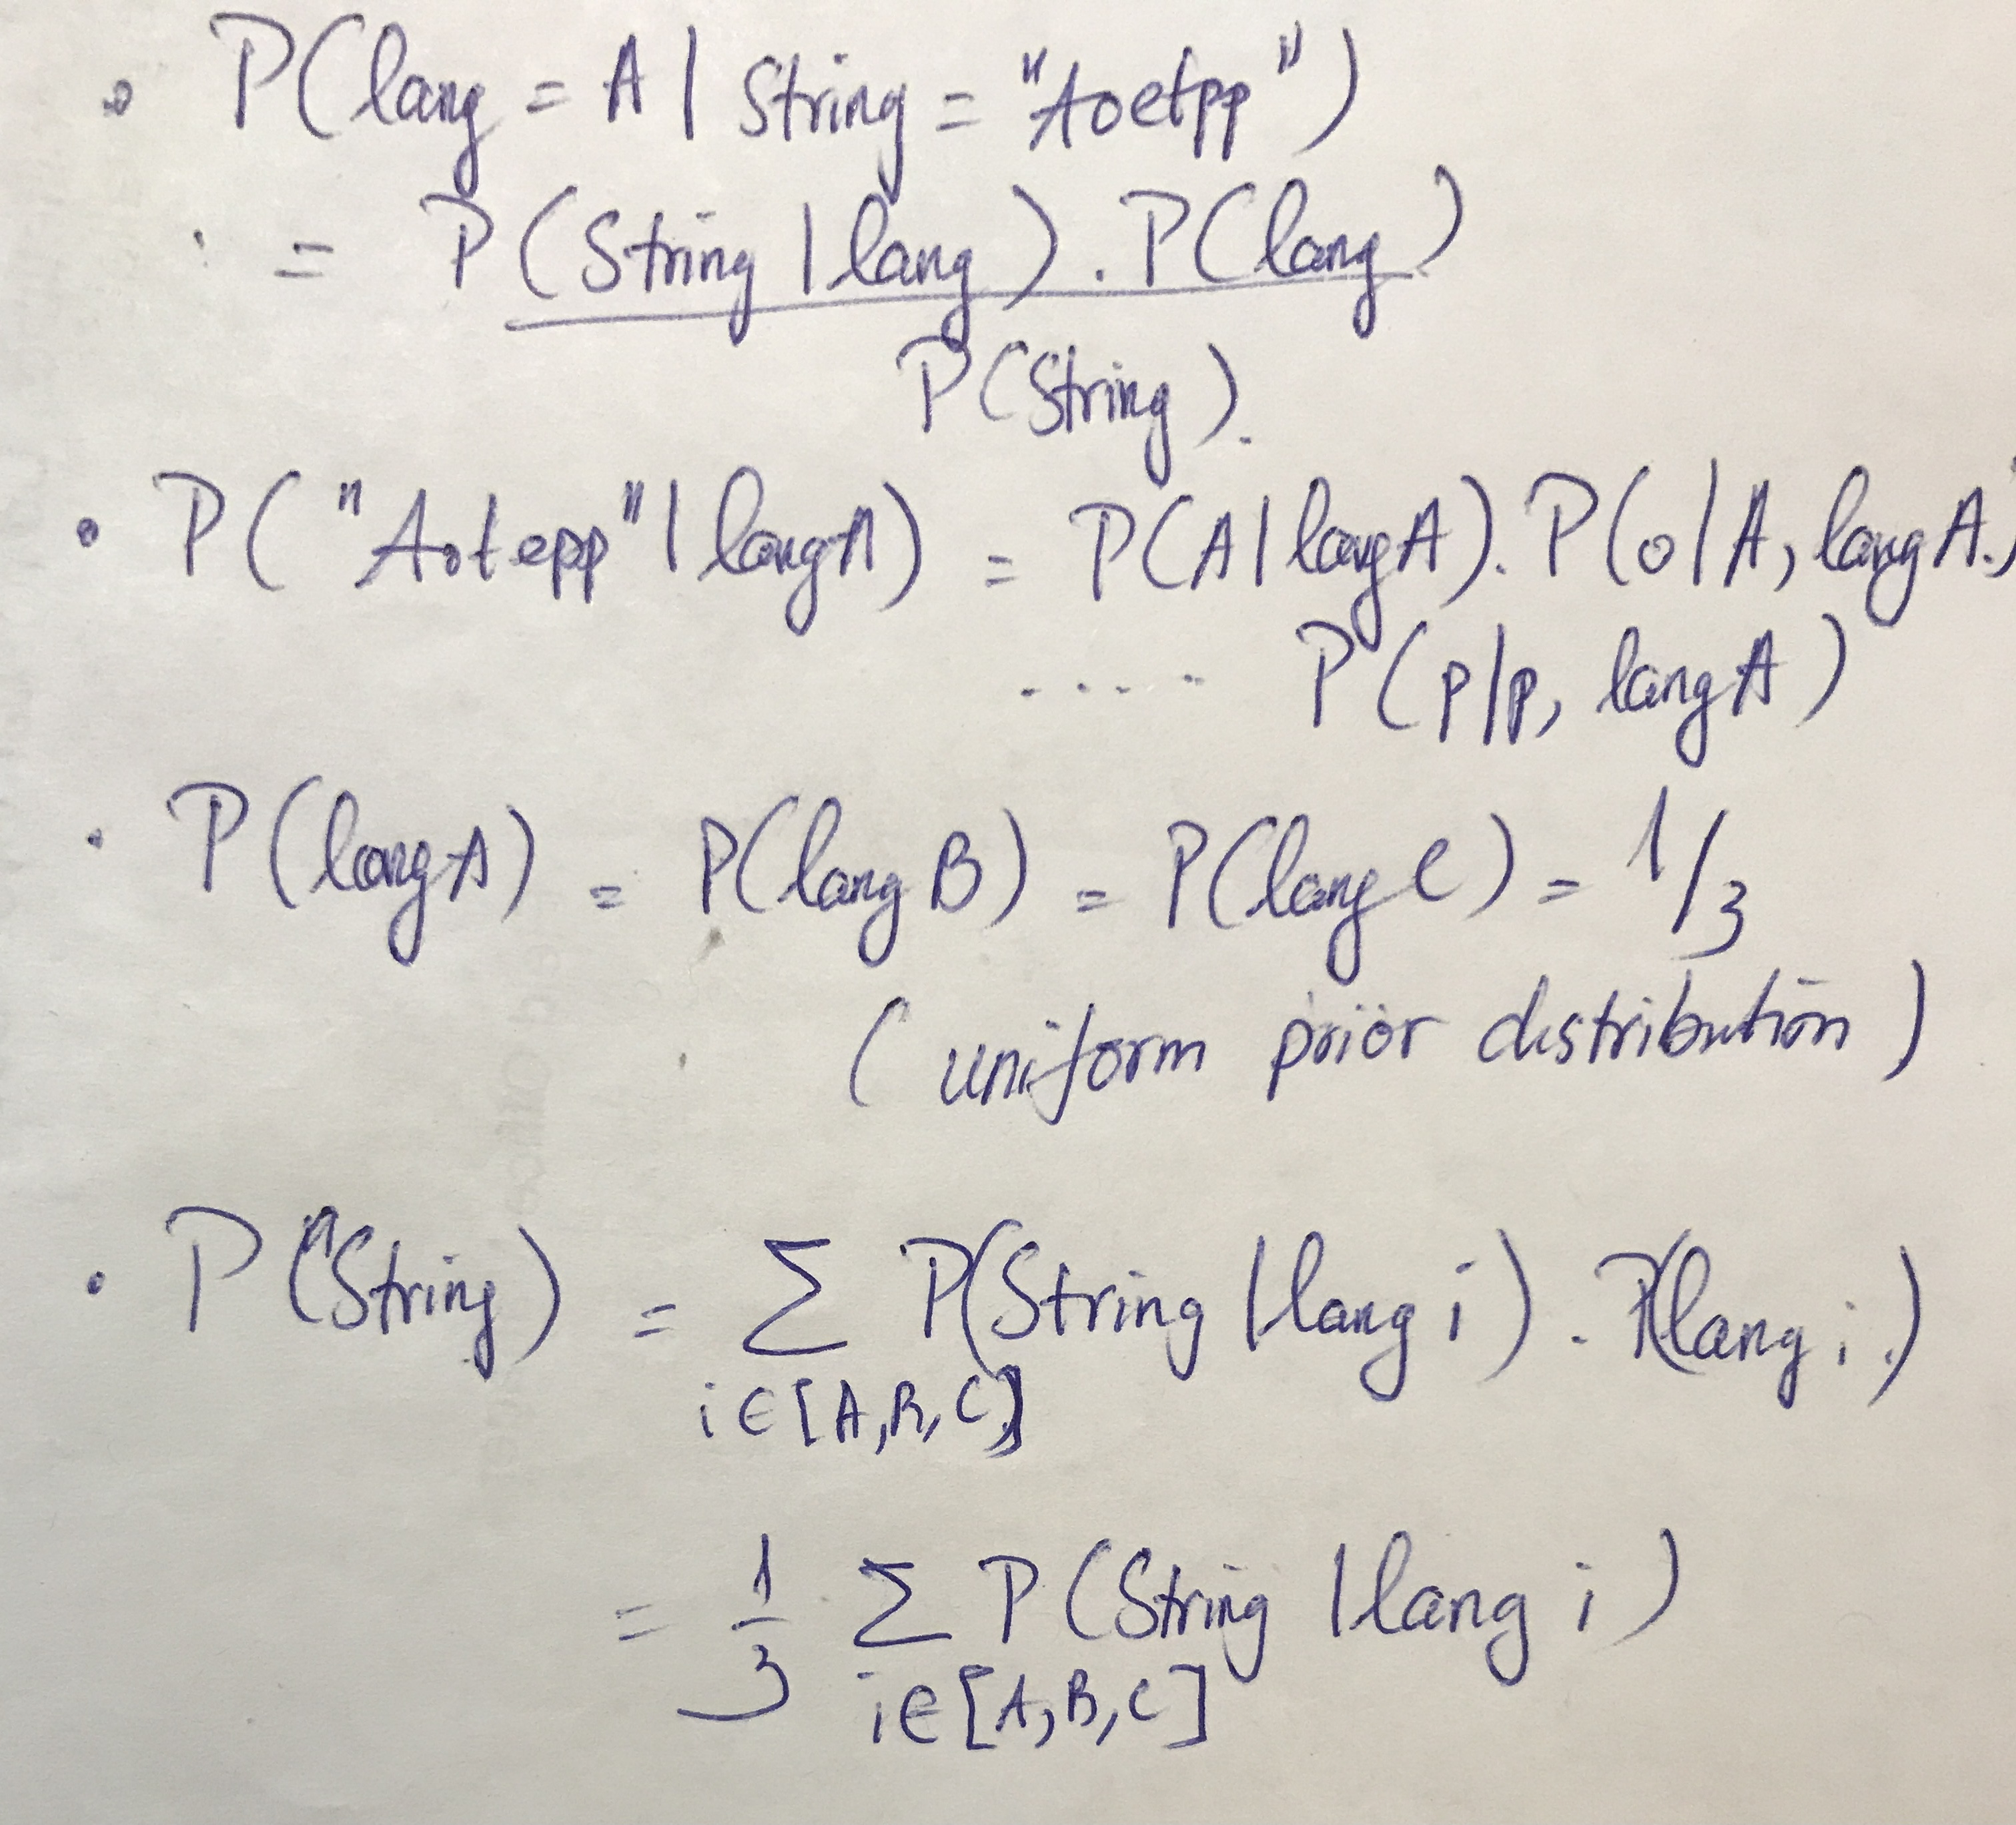

In [49]:
from IPython.display import display, Image
display(Image(filename='assignment7.jpg'))


In [50]:
#calculate the probability of each letter being the starting letter of a word
def prob_letter(letter, lang):
    merged_text = ""
    for j in range(0,30):
        file = "language-training-lang" + str(lang) +"-" + str(j)
        path = root + file
        text = open(path, "r").read()
        merged_text += list(text)[0]
#     print(merged_text)
    list_letter = np.array(list(merged_text))
    p = sum(list_letter == letter)/len(list_letter)
    return(p)
prob_letter("A","A")

0.06666666666666667

In [51]:
#calculate the likelihood
def likelihood(string, lang):
    str_list = list(string)
    transition = markov(lang)
    p = round(prob_letter(str_list[0], lang),2)
    for i in range(0,len(str_list)-1):
        cur = str_list[i]
        nex = str_list[i+1]
        p *= round(transition.loc[cur, nex],3)
    return(p)
        


In [52]:
likelihood("Aoetpp", "A")

4.9729680000000006e-08

In [53]:
#calculate the posterior distribution
def post(string):
    post_list = []
    for lang in ['A', 'B', 'C']:
        like = likelihood(string, lang)
        prior = 1/3
        norm = 0
        for i in ['A', 'B', 'C']:
            norm += likelihood(string, i)
        norm = norm/3
        post = like*prior/norm
        post_list.append(post)
    return(post_list)

In [54]:
post("Aoetpp")

[0.021307651494634906, 0.0, 0.9786923485053651]

In [55]:
#test the algorithm with the provided testing data
for j in range(1,10):
    file = "language-test" +"-" + str(j)
    path = root + file
    text = open(path, "r").read()
    print("Test", j)
    print('Posterior distribution is', post(text))
    print("*****")

Test 1
Posterior distribution is [7.239956532603054e-68, 0.0, 1.0]
*****
Test 2
Posterior distribution is [0.9999999999999998, 0.0, 2.818519345297432e-34]
*****
Test 3
Posterior distribution is [1.3207643868905737e-46, 1.0, 6.308209664200927e-59]
*****
Test 4
Posterior distribution is [1.0, 0.0, 8.570856895948386e-47]
*****
Test 5
Posterior distribution is [1.0, 0.0, 1.0285481748905872e-39]
*****
Test 6
Posterior distribution is [5.406928561652442e-63, 0.9999999999999999, 2.2572437400616117e-62]
*****
Test 7
Posterior distribution is [1.0, 0.0, 4.891349679863045e-42]
*****
Test 8
Posterior distribution is [2.961925689399045e-81, 0.0, 1.0]
*****
Test 9
Posterior distribution is [0.9999999999999999, 0.0, 2.8544836636457635e-46]
*****


# Question 2

# Formula
<p>Thanks to suggestions of Quang Tran</p>
$\Theta$ represents the setting of the model at a time step which includes $\pi$, transition matrix Z, emission matrix B. Using $\Theta^{old}$ we can compute the following parameters:

$$\gamma(z_{n})=p(z_n | X, \Theta^{old})$$
$$\eta(z_{n-1},z_n)=p(z_{n-1},z_n | X, \Theta^{old})$$

According to Bishop (2006) (in Pattern Recognition And Machine Learning) and Degirmenci (2014) (in Introduction to Hidden Markov Models), we update parameters by the following formulae:

$$\pi_k=\frac{\gamma(z_{1k})}{\sum_{j=1}^{3}\gamma(z_{1j})}$$

$$A_{jk}=\frac{\sum_{n=2}^{1000}\eta(z_{n-1,j},z_{nk})}{\sum_{l=1}^{3}\sum_{n=2}^{1000}\eta(z_{n-1,j},z_{nl})}$$

$$B_{ik}=\frac{\sum_{n=1}^{1000}\gamma(z_{nk})x_{ni}}{\sum_{n=1}^{1000}\gamma(z_{nk})}$$

With these updated parameters, we obtain $\Theta^{new}$

1. we should not intialize everything the same as the result would not change over iterations

2. If any element of $\pi$ or A is 0 then that element remains 0 in all updates. Therefore, we avoide zero initialization.

In [56]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [57]:
letter_list = ["A" ,"o", 'e', 't', 'p', 'g', 'k']
text = list(open('speaker.txt', 'r') .read())
text_encoded = []
for letter in text:
    text_encoded.append([letter_list.index(letter)])
X = np.array(text_encoded)

In [76]:
# tutorial in https://hmmlearn.readthedocs.io/en/latest/tutorial.html suggest we should try different starting set of starting prob, transition and emission matrices

lang_model = hmm.MultinomialHMM(n_components=3, n_iter=100, init_params = 'e')

lang_model.startprob_ = np.array([0.2, 0.3, 0.5]) #random starting probability

#random and normalize transition matrix
lang_model.transmat_ = np.random.rand(3,3) 
lang_model.transmat_ /= np.reshape(np.sum(lang_model.transmat_,axis=1), (3,1)) 



lang_model.fit(X)

MultinomialHMM(init_params='e', n_components=3, n_iter=100,
               random_state=RandomState(MT19937) at 0x10FD847C0)

In [77]:
# the predicted probabilities
prob_emission = lang_model.predict_proba(X)
print(prob_emission)

[[1.31739071e-58 1.28594346e-33 1.00000000e+00]
 [4.82143541e-03 3.43902081e-02 9.60788357e-01]
 [1.07235008e-03 4.29298221e-03 9.94634668e-01]
 ...
 [7.17172444e-03 8.70157271e-01 1.22671005e-01]
 [2.73530847e-03 9.60262371e-01 3.70023207e-02]
 [8.36434116e-03 9.57911181e-01 3.37244774e-02]]


In [81]:
lang_model.transmat_
#the transition matrix seems close to 
#[[0.9 0.05 0.05]
# [0.05 0.9 0.05]
# [0.05 0.05 0.9]]
# this matrix is in line with the fact that one person speak 10 words in a row, meaning if person 1 speaks the first word, there is 90% chance he will speak the next one, the remaining 10% splits equually for person 2 and 3 

array([[0.88760289, 0.04332557, 0.06907154],
       [0.04221963, 0.90398397, 0.0537964 ],
       [0.07170339, 0.07527007, 0.85302654]])

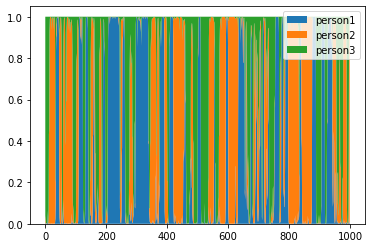

In [78]:
x = list(range(len(X)))
person1 = prob_emission[:,0]
person2 = prob_emission[:,1]
person3 = prob_emission[:,2]
labels = ["person1", "person2", "person3"]

fig, ax = plt.subplots()
ax.stackplot(x, person1, person2, person3, labels=labels)
ax.legend()
# plt.show()


In [79]:
lang_model.score(X)

-1647.3774061900028